In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Esercizio 5") \
    .master("local") \
    .getOrCreate()
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 20:13:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Dati temperatura Lugano




In [2]:
lugano = spark.sparkContext.textFile("lugano.txt")

In [3]:
def clean(line):
    if line.strip() != "":
        try:
            float(line.split(";")[2])
            return True
        except:
            return False
    return False

cleaned = lugano.filter(clean)
cleaned.take(5)
cleaned.count()



1941171

In [4]:
from pyspark.sql import Row
from pyspark.sql.functions import unix_timestamp

luganoRows = cleaned.map(lambda p: Row(name=p.split(";")[0], date=p.split(";")[1][0:8], temp=float(p.split(";")[2])))
luganoDF = luganoRows.toDF()
luganoDF.printSchema()

root
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- temp: double (nullable = true)



In [5]:
luganoDF2 = luganoDF.withColumn("datetime", unix_timestamp("date", "yyyyMMdd").cast("timestamp"))
luganoDF2.printSchema()

root
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- datetime: timestamp (nullable = true)



In [6]:
from pyspark.sql.functions import *

luganoDF2.select(
    min(luganoDF2.temp).alias("min"),
    max(luganoDF2.temp).alias("max"), 
    mean(luganoDF2.temp).alias("mean"), 
    stddev(luganoDF2.temp).alias("sd"),
    count(luganoDF2.temp).alias("count"),
).collect()

[Row(min=-49.8, max=48.5, mean=13.038331811058942, sd=7.501534667983691, count=1941171)]

In [7]:
luganoDF.describe().show()

+-------+-------+-------------------+------------------+
|summary|   name|               date|              temp|
+-------+-------+-------------------+------------------+
|  count|1941171|            1941171|           1941171|
|   mean|   null|2.005110770872118E7|13.038331811058942|
| stddev|   null| 106526.67229139266| 7.501534667983691|
|    min|    LUG|           19870131|             -49.8|
|    max|    LUG|           20231231|              48.5|
+-------+-------+-------------------+------------------+



In [8]:
import pyspark.sql.functions as F

extended = luganoDF2.select("*", 
    F.date_format(luganoDF2.datetime, 'dd').alias("day"),
    F.date_format(luganoDF2.datetime, 'MM').alias("month"),
    F.date_format(luganoDF2.datetime, 'yyyy').alias("year")
)
extended.printSchema()

root
 |-- name: string (nullable = true)
 |-- date: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- datetime: timestamp (nullable = true)
 |-- day: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)



In [14]:
extended.show()

23/04/20 17:44:18 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 14 (TID 12): Attempting to kill Python Worker
+----+--------+----+-------------------+---+-----+----+
|name|    date|temp|           datetime|day|month|year|
+----+--------+----+-------------------+---+-----+----+
| LUG|19870201|-1.8|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-1.8|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.0|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.0|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.1|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.1|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.2|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.0|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.0|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.1|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.2|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.2|1987-02-01 00:00:00| 01|   02|1987|
| LUG|19870201|-2.3|1987

In [9]:
extended.groupBy("year").mean("temp").orderBy("year").show()

+----+------------------+
|year|         avg(temp)|
+----+------------------+
|1987|12.609940079754475|
|1988|12.381475789313907|
|1989|12.285871385083706|
|1990|12.658131659056473|
|1991|12.365108909379032|
|1992|12.377701882209953|
|1993|12.131948249619393|
|1994|13.190601217655882|
|1995|12.467914764079072|
|1996|12.105940725561618|
|1997| 13.00314117199389|
|1998|12.460222602739831|
|1999|12.578027016742771|
|2000|12.963545461445031|
|2001|12.767404870623942|
|2002|13.149815449010502|
|2003|13.756527447436167|
|2004| 12.64842896174871|
|2005| 12.61109398782343|
|2006|13.100783866058082|
+----+------------------+
only showing top 20 rows



In [10]:
extended.createOrReplaceTempView("lugano")

In [11]:
sqlDF = spark.sql("SELECT * FROM lugano")
sqlDF.show()

+----+--------+----+-------------------+---+-----+----+
|name|    date|temp|           datetime|day|month|year|
+----+--------+----+-------------------+---+-----+----+
| LUG|19870131|-0.5|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.5|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.7|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.8|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-1.0|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.9|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-0.9|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-1.0|1987-01-31 00:00:00| 31|   01|1987|
| LUG|19870131|-1.0|1987-01-31 00:00:00| 31|   0

24/04/08 20:14:58 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 12 (TID 13): Attempting to kill Python Worker


In [12]:
spark.sql("SELECT year, avg(temp) FROM lugano group by year order by year").show()

+----+------------------+
|year|         avg(temp)|
+----+------------------+
|1987|12.609940079754475|
|1988|12.381475789313907|
|1989|12.285871385083706|
|1990|12.658131659056473|
|1991|12.365108909379032|
|1992|12.377701882209953|
|1993|12.131948249619393|
|1994|13.190601217655882|
|1995|12.467914764079072|
|1996|12.105940725561618|
|1997| 13.00314117199389|
|1998|12.460222602739831|
|1999|12.578027016742771|
|2000|12.963545461445031|
|2001|12.767404870623942|
|2002|13.149815449010502|
|2003|13.756527447436167|
|2004| 12.64842896174871|
|2005| 12.61109398782343|
|2006|13.100783866058082|
+----+------------------+
only showing top 20 rows



In [15]:
luganoRDD = spark.sql("SELECT year, avg(temp) FROM lugano group by year order by year").rdd

In [16]:
luganoRDD.map(lambda r: (r[0],r[1])).take(5)

[('1987', 12.609940079754475),
 ('1988', 12.381475789313907),
 ('1989', 12.285871385083706),
 ('1990', 12.658131659056473),
 ('1991', 12.365108909379032)]

In [19]:
#Pivot
extended.groupBy("year").pivot("month",  ["01", "02"]).mean("temp").orderBy("year").show(40)

+----+-------------------+------------------+
|year|                 01|                02|
+----+-------------------+------------------+
|1987|-0.7208333333333338|3.9490079365079365|
|1988|  4.579637096774185| 5.258117816091952|
|1989| 3.3469086021505383| 5.767137896825386|
|1990|  2.526993727598567| 7.074875992063496|
|1991|  3.034363799283159|2.5046626984126994|
|1992|  3.010797491039433| 5.774688697318009|
|1993| 3.8200940860215105| 4.345312499999995|
|1994|  4.527889784946228|3.8477678571428586|
|1995|  3.042831541218637|  6.28732638888888|
|1996|    4.4456317204301|3.6754789272030775|
|1997| 3.7414874551971375| 6.294419642857146|
|1998| 3.9593637992831434| 6.711135912698412|
|1999|  3.856272401433706|   4.1544642857143|
|2000| 3.4504480286738315| 6.161398467432961|
|2001|  3.636447132616486| 6.291319444444443|
|2002| 2.3302195340501806| 6.245957341269835|
|2003|  4.043145161290318|2.7835317460317457|
|2004| 3.4818100358422956| 4.637763409961673|
|2005| 3.5363351254480375|3.649627

# Online Retail

Questo dataset continene acquisti effettuati da clienti internazionali su un sito web inglese. Le transazioni coprono il periodo da dicembre 2010 a dicembre 2011.

Per adempiere allo scopo di questo tutorial, il dataset è stato convertito in formato CSV (OnlineRetail.csv).

Il sito originale del dataset è:

https://archive.ics.uci.edu/ml/datasets/Online+Retail

## Loading

Iniziamo con il caricare il dataset e capire un po cosa contiene. In molte situazioni il contenuto e la struttura sono noti. 
Conviene però comuqnue controllare che tutto sia corretto e che non vi sono sorprese.

**NOTA**: La prima linea del file CSV continene i nomi delle colonne. 

<a href="http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader">``spark.read``</a> 
è un istanza di un DataFrameReader. Esso permette di caricare un certo numero di formati file. 
Tutti i formati sono in qualche modo basati su tabelle/record. Il file può trovarsi nel file system locale, su hdfs, jdbc, etc. 

In [21]:
online_retail = spark.read.option("header", True).csv("OnlineRetail.csv")
online_retail.show()

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/10 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/10 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/10 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/10 08:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/10 08:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|01/12/10 08:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|01/12/10 08:26|     4.

Quante righe contiente il file?

In [22]:
online_retail.count()

541909

Mostrare le prime 5 righe.

In [23]:
online_retail.show(5)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|01/12/10 08:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|01/12/10 08:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|01/12/10 08:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|01/12/10 08:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|01/12/10 08:26|     3.39|     17850|United Kingdom|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
only showing top 5 rows



Che tipi di dati abbiamo? Sono tutte stringhe? Oppure ci sono anche altri tipi di dati?

    Ci sono valori numerici (Quantity e UnitPrice) e date (InvoicePrice)

Quale schema ha creato Spark per questi dati? (hint: Usare printSchema())

In [24]:
online_retail.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)



Ricaricare il file ma questa volta specificando manualmente lo schema del dataset

In [25]:
from pyspark.sql.types import *
schema = StructType([
    StructField("InvoiceNo",   StringType(),  True),
    StructField("StockCode",   StringType(),  True),
    StructField("Description", StringType(),  True),
    StructField("Quantity",    IntegerType(), True),
    StructField("InvoiceDate", StringType(),  True),
    StructField("UnitPrice",   DoubleType(),  True),
    StructField("CustomerID",  IntegerType(), True),
    StructField("Country",     StringType(),  True)
])

In [26]:

online_retail = (spark
                 .read
                 .option("header", True)
                 .schema(schema)
                 .csv("OnlineRetail.csv"))

Quale schema ha questo dataframe, ora?

In [27]:
online_retail.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



## Conversione della data

La data (InvoiceDate) non è stata riconosciuta come tale.
Se essa seguisse il formato ``yyyy/MM/dd HH:mm`` un caricamento con ``inferSchema`` capirebbe il tipo. Qui però abbiamo ``dd/MM/yy HH:mm``.

Applicare una conversione utilizzando la funzione ``unix_timestamp``, come fatto in precedenza sui dati di Lugano.

In [28]:
import pyspark.sql.functions as F

online_retail = (online_retail
                 .withColumn("InvoiceDate", 
                     F.unix_timestamp(online_retail.InvoiceDate, "dd/MM/yy HH:mm").
                     cast("timestamp")))

online_retail.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



## Qualche prima statistica

Adesso che abbiamo i tipi corretti possiamo procedere con alcune statistiche sui dati. Queste potrebbero permetterci di capire un po' di più i nostri dati.

Qual è il valore minimo e massimo per la quantità?
Quali Country sono specificate?
Qual è il prezzo minimo e massimo?

Ci sono dei dati un po' sballati, o con poco senso?

In [29]:
online_retail.describe("Quantity", "UnitPrice", "Country").show()

+-------+------------------+-----------------+-----------+
|summary|          Quantity|        UnitPrice|    Country|
+-------+------------------+-----------------+-----------+
|  count|            541909|           541909|     541909|
|   mean|  9.55224954743324|4.611113626083471|       null|
| stddev|218.08115785023355|96.75985306117803|       null|
|    min|            -80995|        -11062.06|  Australia|
|    max|             80995|          38970.0|Unspecified|
+-------+------------------+-----------------+-----------+



In [30]:
online_retail.select("Country").distinct().show(40)

+--------------------+
|             Country|
+--------------------+
|              Sweden|
|           Singapore|
|             Germany|
|                 RSA|
|              France|
|              Greece|
|  European Community|
|             Belgium|
|             Finland|
|               Malta|
|         Unspecified|
|               Italy|
|                EIRE|
|           Lithuania|
|              Norway|
|               Spain|
|             Denmark|
|           Hong Kong|
|             Iceland|
|              Israel|
|     Channel Islands|
|                 USA|
|              Cyprus|
|        Saudi Arabia|
|         Switzerland|
|United Arab Emirates|
|              Canada|
|      Czech Republic|
|              Brazil|
|             Lebanon|
|               Japan|
|              Poland|
|            Portugal|
|           Australia|
|             Austria|
|             Bahrain|
|      United Kingdom|
|         Netherlands|
+--------------------+



Country non specificata ("Unspecified")?

Quantità negative, o troppo alte (80995)?

Prezzi negativi?

## Pivot

La funzione di pivot è disponibile quando si stà raggruppoando valori. Con essa è possibile portare nelle colonne i singoli valori di un attributo.

Usando la funzione <a href="http://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html#pyspark.sql.functions.quarter">``quarter``</a> e la funzione <a href="http://spark.apache.org/docs/2.3.0/api/python/pyspark.sql.html#pyspark.sql.GroupedData.pivot"> ``pivot``</a> applicare una pivot al dataset per visualizzare, per ogni quarter, le vendite in base al giorno della settimana.

In [31]:
extended = online_retail.select("*", 
    F.date_format(online_retail.InvoiceDate, 'E').alias("daynum"),
    F.date_format(online_retail.InvoiceDate, 'yyyy').alias("year"),
    F.quarter(online_retail.InvoiceDate).alias("quarter"),
    F.floor(online_retail.UnitPrice * online_retail.Quantity).alias("sales")
)
extended.select("quarter", "year", "daynum", "InvoiceDate", "sales").show(5)

+-------+----+------+-------------------+-----+
|quarter|year|daynum|        InvoiceDate|sales|
+-------+----+------+-------------------+-----+
|      4|2010|   Wed|2010-12-01 08:26:00|   15|
|      4|2010|   Wed|2010-12-01 08:26:00|   20|
|      4|2010|   Wed|2010-12-01 08:26:00|   22|
|      4|2010|   Wed|2010-12-01 08:26:00|   20|
|      4|2010|   Wed|2010-12-01 08:26:00|   20|
+-------+----+------+-------------------+-----+
only showing top 5 rows



In [32]:
data = extended.groupBy("quarter").pivot("daynum").sum("sales")
data.show()

+-------+------+------+------+------+------+------+
|quarter|   Fri|   Mon|   Sun|   Thu|   Tue|   Wed|
+-------+------+------+------+------+------+------+
|      1|286395|281171|107156|341152|410848|265088|
|      3|337070|339692|218391|575317|471944|379883|
|      4|618292|680239|290188|713541|622829|684621|
|      2|258889|240311|156266|431730|410515|358206|
+-------+------+------+------+------+------+------+



In [33]:
from pyspark.ml.feature import VectorAssembler
d2=VectorAssembler(inputCols=["Mon","Tue","Wed","Thu","Fri", "Sun"], outputCol="qs").transform(data)
print(d2)
series = d2.select(data.quarter.alias("series"), d2.qs).collect()

DataFrame[quarter: int, Fri: bigint, Mon: bigint, Sun: bigint, Thu: bigint, Tue: bigint, Wed: bigint, qs: vector]


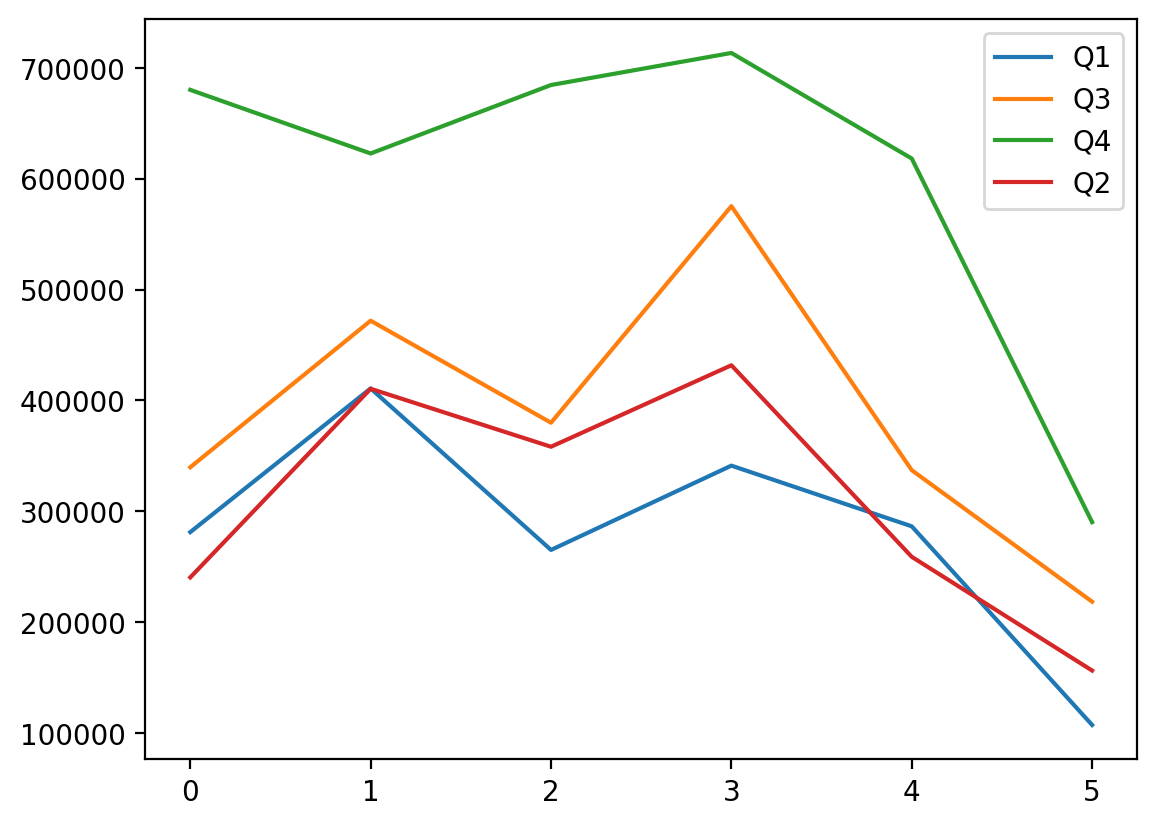

In [34]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

for quarter in series:
    plt.plot(quarter.qs, label="Q%s"%quarter.series)

plt.legend()
plt.show()